In [1]:
import pandas as pd
import numpy as np
import keras
import crested
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams["pdf.fonttype"] = 42  
matplotlib.rcParams["ps.fonttype"] = 42  
from pathlib import Path
import anndata

from scoring_utils import *

2025-03-20 15:41:01.630347: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 15:41:01.672976: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-20 15:41:05.270697: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Download the data for the notebooks from the dedicated Zenodo link of the CREsted paper. Then use it below.

In [2]:
DATA_DIR ="../../../crested_data/Figure_2/"

# Load mm10 and hg38 genome

This notebook requires an mm10 and hg38 fasta file and an mm10 and hg38 chromosome sizes file. You can download that here for example: https://hgdownload.soe.ucsc.edu/downloads.html 
Once downloaded, we load them to the notebook.

In [3]:
genome_dir = "../../../mouse/biccn/"
genome_fasta = f"{genome_dir}mm10.fa"
genome_chrom_sizes  = f"{genome_dir}mm10.chrom.sizes" 

In [4]:
genome = crested.Genome(genome_fasta, genome_chrom_sizes)
crested.register_genome(genome)

2025-03-20T15:41:22.072731+0100 INFO Genome mm10 registered.


In [5]:
genome_mm = "../../../mouse/biccn/mm10.fa"
genome_hg = "../../../human/genome/hg38.fa"

In [6]:
import pysam

pysam_mm = pysam.FastaFile(genome_mm)
pysam_hg = pysam.FastaFile(genome_hg)

# Load enhancer data

In [7]:
df = pd.read_csv(f'{DATA_DIR}biccn_enhancers.csv')
df

,old_idx,chrom,start,end,name,target_ct,second_target_ct,specificity,strength,enhancerID,species
0,9,chr1,46868072,46868423,chr1:46868072-46868423,L6_IT_Car3,NaN,On-Target,strong,AiE2051m,mouse
1,18,chr1,81508154,81508487,chr1:81508154-81508487,SstChodl,NaN,On-Target,strong,AiE0465m,mouse
2,19,chr1,90560790,90561290,chr1:90560790-90561290,Sncg,NaN,On-Target,strong,AiE0492m,mouse
3,21,chr1,120215946,120216285,chr1:120215946-120216285,L5ET,NaN,On-Target,strong,AiE0462m,mouse
4,25,chr1,126153519,126154399,chr1:126153519-126154399,L5_6NP,NaN,On-Target,weak,AiE2443m,mouse
...,...,...,...,...,...,...,...,...,...,...,...
166,667,chr8,56293639,56294037,chr8:56293639-56294037,Sst,SstChodl,On-Target,weak,AiE0529h,human
167,672,chr9,81717533,81717734,chr9:81717533-81717734,Oligo,NaN,On-Target,weak,AiE0410h,human
168,673,chr9,123741899,123742461,chr9:123741899-123742461,Astro,NaN,On-Target,weak,AiE0385h,human
169,674,chr9,128374068,128374662,chr9:128374068-128374662,Oligo,NaN,On-Target,strong,AiE0395h,human


## One-hot encode sequences

We will embed enhancers in zero-padded background sequences.

In [8]:
seq_len=2114
hot_encoding_table = get_hot_encoding_table()
# One-hot encode the sequences and concatenate the results
seqs_one_hot = one_hot_encode_sequences(df, seq_len, pysam_mm, pysam_hg, hot_encoding_table)

# Check the shape of the resulting concatenated array
print(seqs_one_hot.shape)

100%|██████████| 49/49 [00:00<00:00, 12739.16it/s]

(171, 2114, 4)


# Load models and make predictions

In [9]:
adata = anndata.read_h5ad(f"{DATA_DIR}mouse_cortex_filtered.h5ad")

In [10]:
model_path =f"{DATA_DIR}DeepBICCN2.keras"
model = keras.models.load_model(
    model_path, compile=False
)

2025-03-20 15:41:23.959885: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78790 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:e4:00.0, compute capability: 9.0


In [11]:
model_path =f"{DATA_DIR}DeepBICCN2_basemodel.keras"
basemodel = keras.models.load_model(
    model_path, compile=False
)

## Load DeepBICCN
To compare against the orignal DeepBICCN model (Johansen & Kempynck et al., 2024), we can load it from through CREsted.

In [12]:
model_path, output_names = crested.get_model('BICCN')
model_og = keras.models.load_model(model_path)

## Model predictions on enhancer set

In [13]:
model_names = ['DeepBICCN','DeepBICCN2_base','DeepBICCN2']
models = [model_og, basemodel, model]

In [14]:
all_preds = []

for model_ in models:
    preds = crested.tl.predict(seqs_one_hot, model_)
    preds[preds<0]=0 # Negative predictions possible in original DeepBICCN
    all_preds.append(preds)

I0000 00:00:1742481686.437326 3885327 service.cc:145] XLA service 0x7febd4014bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742481686.437358 3885327 service.cc:153]   StreamExecutor device (0): NVIDIA H100 80GB HBM3, Compute Capability 9.0
2025-03-20 15:41:26.455052: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-20 15:41:26.540327: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step


I0000 00:00:1742481687.268091 3885327 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step


In [15]:
classes = np.array(['Astro', 'Endo', 'L2_3IT', 'L5ET', 'L5IT', 'L5_6NP', 'L6CT',
       'L6IT', 'L6b', 'Lamp5', 'Micro_PVM', 'OPC', 'Oligo', 'Pvalb',
       'Sncg', 'Sst', 'SstChodl', 'VLMC', 'Vip'])
classes

array(['Astro', 'Endo', 'L2_3IT', 'L5ET', 'L5IT', 'L5_6NP', 'L6CT',
       'L6IT', 'L6b', 'Lamp5', 'Micro_PVM', 'OPC', 'Oligo', 'Pvalb',
       'Sncg', 'Sst', 'SstChodl', 'VLMC', 'Vip'], dtype='<U9')

## Mapping model classes to enhancer annotation

We need to manually map the cell types from the enhancer set to those in the dataset. We just make a dictionary with key the dataframe cell type and value the corresponding cell type from the model.

In [16]:
df_to_class_mapping_mm = {
    'Astro': 'Astro',
    'Endo': 'Endo',
    'L2_3IT': 'L2_3IT',
    'L5IT': 'L5IT',
    'L5ET': 'L5ET',
    'L5_6NP': 'L5_6NP',
    'L6CT': 'L6CT',
    'L6IT': 'L6IT',
    'L6b': 'L6b',
    'Lamp5': 'Lamp5',
    'Micro_PVM': 'Micro_PVM',
    'OPC': 'OPC',
    'Oligo': 'Oligo',
    'Pvalb': 'Pvalb',
    'Sncg': 'Sncg',
    'Sst': 'Sst',
    'SstChodl': 'SstChodl',
    'VLMC': 'VLMC',
    'Vip': 'Vip',
    'L4IT': 'L5IT',
    'L6_IT_Car3': 'L6IT',
    'Lamp5_Lhx6': 'Lamp5',
    'Pvalb_Chc': 'Pvalb', 
}

In [17]:
# Replace values in 'target_ct' and 'second_target_ct' using the mapping dictionary
df['target_ct'] = df['target_ct'].map(df_to_class_mapping_mm)
df['second_target_ct'] = df['second_target_ct'].map(df_to_class_mapping_mm)

In [18]:
df.iloc[117]

old_idx                                  513
chrom                                   chr9
start                              104691310
end                                104691762
name                chr9:104691310-104691762
target_ct                               L6IT
second_target_ct                         NaN
specificity                        On-Target
strength                              strong
enhancerID                          AiE2596m
species                                mouse
Name: 117, dtype: object

# Load scATAC-seq data

In [19]:
bw_folder_mm = f'{DATA_DIR}cut_sites_bws/' # From Zemke et al., 2023, processed with pycistopic
bw_folder_hg = f'{DATA_DIR}human_cut_sites_bws/' # From Zemke et al., 2023 , processed with pycistopic

scores = np.zeros((len(df),len(classes)))
scores_norm = np.zeros((len(df),len(classes)))

for idx, row in df.iterrows():
    bw_f = None
    norm_factor=None
    if row['species']=='mouse':
        bw_f = bw_folder_mm
        norm_factor = adata.obsm['weights']
    else:
        bw_f = bw_folder_hg
        norm_factor = np.array([1.61026241, 1.30942467, 3.47435071, 3.37818102, 3.7605314,  3.23270051, 3.40177282, 3.33, 3.37347138, 3.0893015,  1.37123788, 1.68681267, 1.45355721, 3.43004421, 3.03307429, 2.71549526, 1.95764051, 1., 2.79151513]) #3.53889357, 3.14485354 L6It is the merged L6IT and L6ITCar3
    for j, ct in enumerate(classes):
        values = np.array(crested.utils.read_bigwig_region(bw_f+ct+'.bw', (row['chrom'], row['start'], row['end']))[0])
        if(len(values)<1000):
            values = np.concatenate((values,np.zeros(1000-len(values))))
        score = np.sum(values)
        scores[idx,j] = score
    scores_norm[idx] = scores[idx]*norm_factor 

In [20]:
all_preds.append(scores)
model_names.append('scATAC')
all_preds.append(scores_norm)
model_names.append('scATAC (peak-scaled)')

# Binary scoring of models
We can first do easy scoring of regions and assing the predicted cell type just as the maximal prediction per region.

In [21]:
prediction_dict = {}

for i in range(len(seqs_one_hot)):
    prediction_dict[df.iloc[i]['enhancerID']] = {}
    for j, pred in enumerate(all_preds):
        prediction_dict[df.iloc[i]['enhancerID']][model_names[j]] = classes[np.argmax(pred[i])]

## fig. S3A

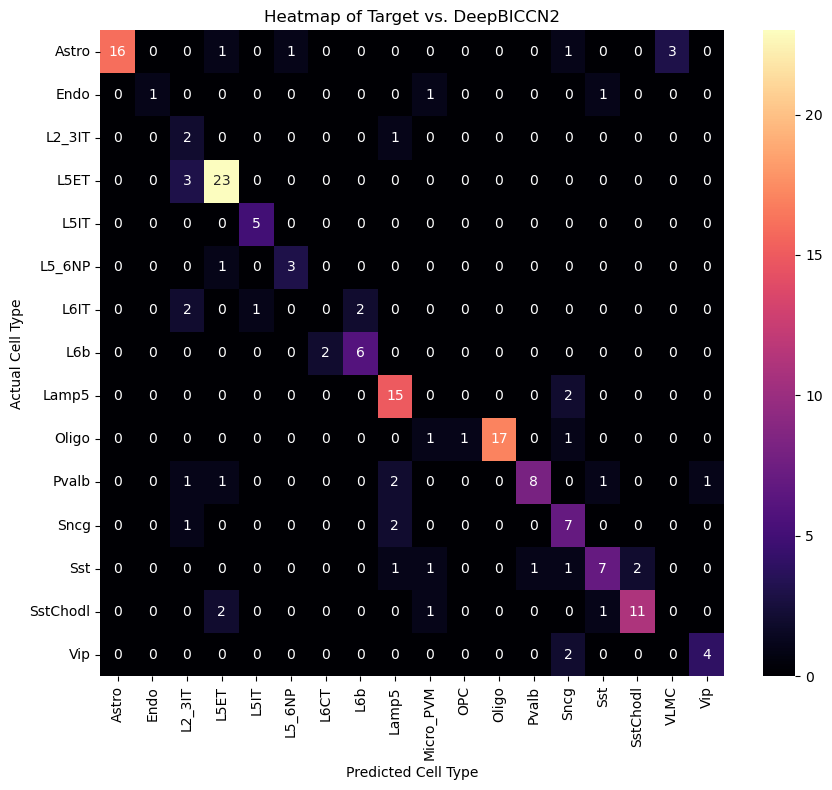

In [22]:
plot_prediction_heatmaps(df, prediction_dict, ['DeepBICCN2'],figsize_scale=9)#, save_file='preds.pdf')

In [23]:
performance_df = calculate_performance_metrics(df, prediction_dict, model_names)
performance_df

/home/VIB.LOCAL/niklas.kempynck/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/VIB.LOCAL/niklas.kempynck/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/VIB.LOCAL/niklas.kempynck/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

,accuracy,precision,recall,f1_score
DeepBICCN,0.690058,0.781373,0.690058,0.703146
DeepBICCN2_base,0.678363,0.781500,0.678363,0.699210
DeepBICCN2,0.730994,0.797486,0.730994,0.749440
scATAC,0.847953,0.891294,0.847953,0.855699
scATAC (peak-scaled),0.824561,0.843094,0.824561,0.826986


# Complete scoring

Just doing a binary prediction already gives some insights in how well the model works, but it does not give an idea of how strong and specific your predictions were.
Ideally, if an enhancer is only active in one cell type, the model should predict a strong peak only there, and close to zero everywhere else. For this, we will also take the off-target predictions into account. We do this by calculating specificity over all cell types.

In [24]:
score_list = []
for preds in all_preds:
    score_list.append(calculate_specificity(preds))
    
score_names = model_names

In [25]:
# We assign ground truth values based on the enhancer labels.
import numpy as np
import pandas as pd
from tqdm import tqdm

# Initialize ground truth values array
gt_values = np.zeros_like(score_list[0], dtype=int)

# Iterate through DataFrame rows
for index, row in tqdm(df.iterrows(), total=len(df)):
    annots = np.array(classes)
    
    # Get the first and second target cell types
    first_target = row['target_ct']
    second_target = row['second_target_ct']

    # Find indices of the mapped classes in annotations
    idx_1 = np.argwhere(annots == first_target).flatten() if first_target else None
    idx_2 = np.argwhere(annots == second_target).flatten() if second_target else None

    # Assign 1 to the corresponding indices in gt_values
    if idx_1 is not None:
        gt_values[index, idx_1] = 1
    if idx_2 is not None:
        gt_values[index, idx_2] = 1
        

100%|██████████| 171/171 [00:00<00:00, 24829.54it/s]


chr11:3508976-3509602
AiE0816m


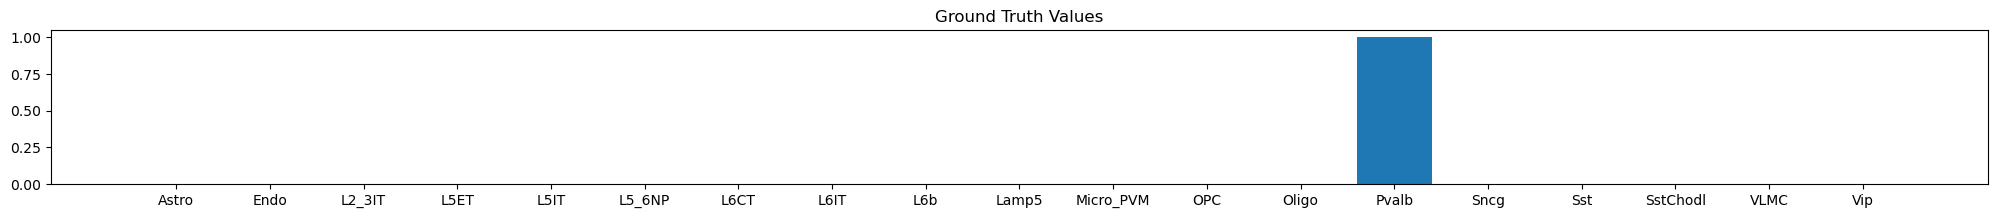

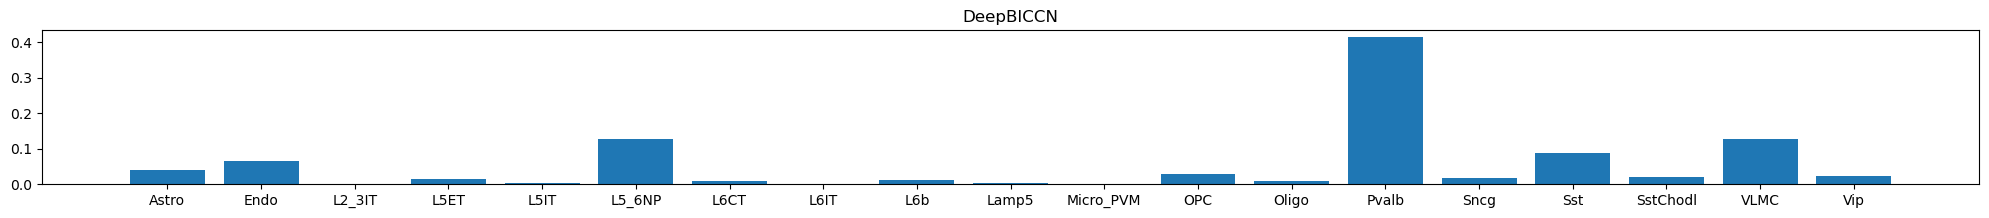

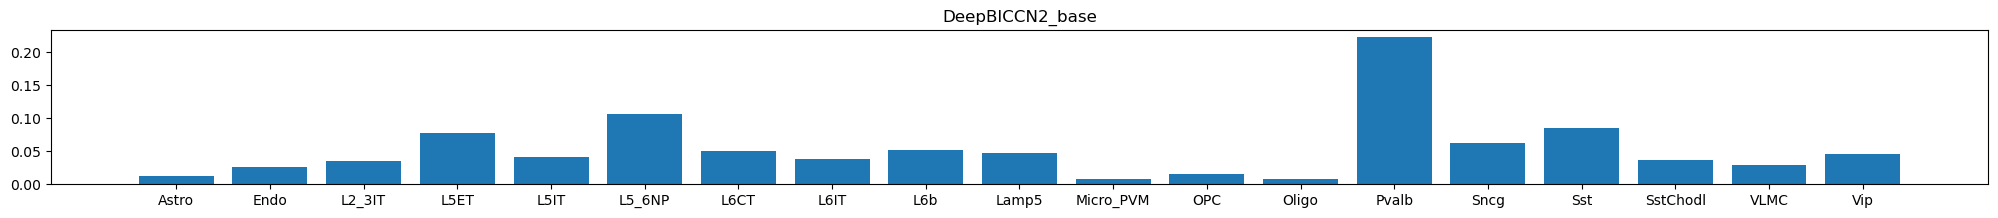

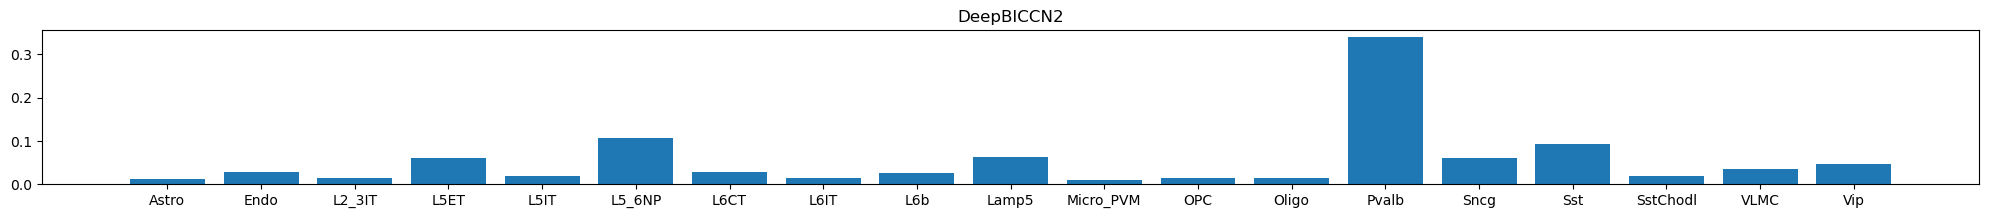

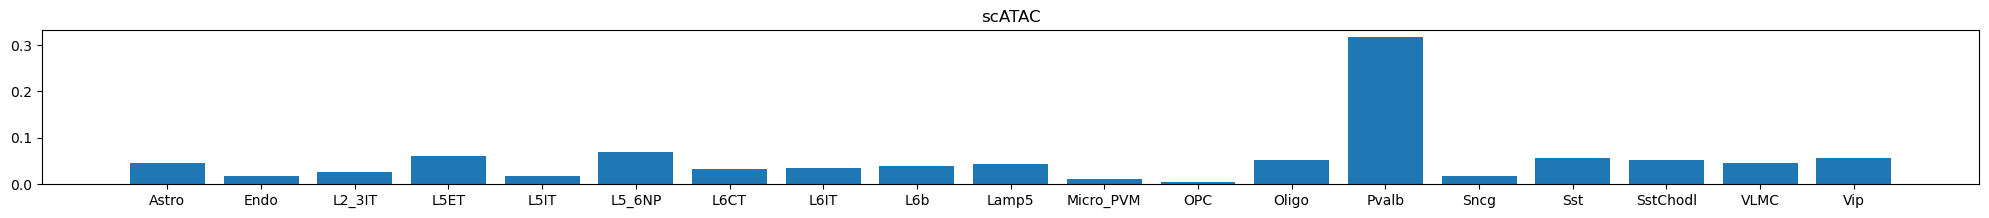

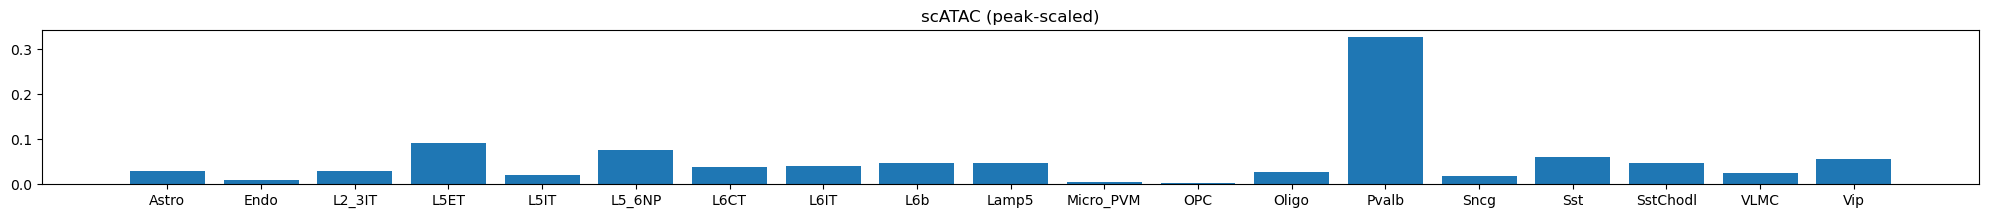

In [26]:
# Example region ground truth (top) and specificity scores (note: not raw predictions!).
index=12
print(df.iloc[index]['name'])
print(df.iloc[index]['enhancerID'])

plot_bar_for_scores(index, classes, gt_values, score_list, scoring_labels=score_names)

## Fig. S3B

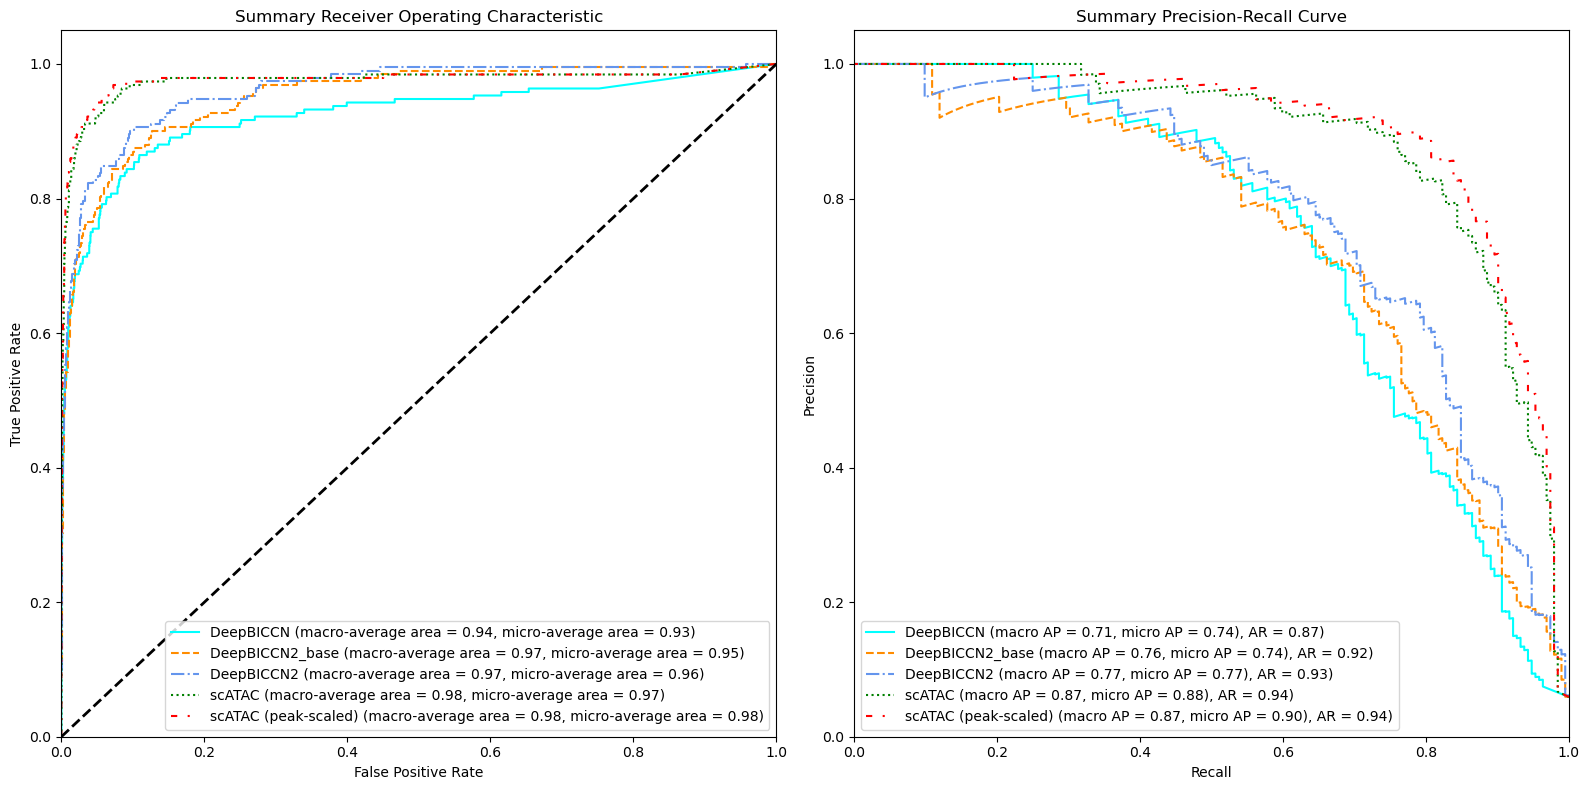

In [27]:
models_data_all = []
for i, score in enumerate(score_list):
    dict1 = {}
    dict1['name']=score_names[i]
    dict1['y_score']= score_list[i]
    dict1['y_true']= gt_values
    models_data_all.append(dict1)

plot_summary_roc_aupr(models_data_all)#, file='scoring.pdf')

# Example enhancer regions

In [28]:
def one_hot_to_dna(one_hot: np.ndarray) -> str:
    # Define the mapping from index to base
    bases = np.array(['A', 'C', 'G', 'T', 'N'])
    
    # Ensure the input is valid
    if one_hot.shape[1] != 4:
        raise ValueError("Input must be a 2D array with exactly 4 columns (A, C, G, T).")
    if not np.all((one_hot.sum(axis=1) == 1) | (one_hot.sum(axis=1) == 0)):
        raise ValueError("Each row in the input must have exactly one '1' or be all zeros.")

    # Handle rows with all zeros by appending 'N' for those cases
    indices = np.where(one_hot.sum(axis=1) == 0, 4, np.argmax(one_hot, axis=1))
    
    # Map the indices to bases
    sequence = ''.join(bases[indices])
    
    return sequence
    
def get_score_list(enh_idx, df, seqs_one_hot, models, cts_=None):
    sequence = one_hot_to_dna(seqs_one_hot[enh_idx])
    row = df.iloc[enh_idx]
    first_target = row['target_ct']
    second_target = row['second_target_ct']
    enhancerid = row['enhancerID']
    
    # Find indices of the mapped classes in annotations
    ct1=first_target
    ct2= None if second_target not in classes else second_target
    
    if ct2:
        cts = [ct1,ct2]
    else:
        cts=[ct1]
    if cts_:
        cts=cts_

    class_idx = list(adata.obs_names.get_indexer(cts))
        
    scores_list = []
    for model_ in models:
        scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
            sequence,
            target_idx=class_idx,
            model=model_,
        )
        scores_list.append(scores)
    return scores_list, sequence, one_hot_encoded_sequences, cts, row, enhancerid

## SstChodl enhancer AiE4246m

In [29]:
scores_list, sequence, one_hot_encoded_sequences, cts, row, enhancerid = get_score_list(27,df,seqs_one_hot,models)

2025-03-20T15:41:34.403717+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:03<00:00,  3.21s/it]

2025-03-20T15:41:37.616588+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).



Model: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

2025-03-20T15:41:38.986015+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).



Model: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
DeepBICCN


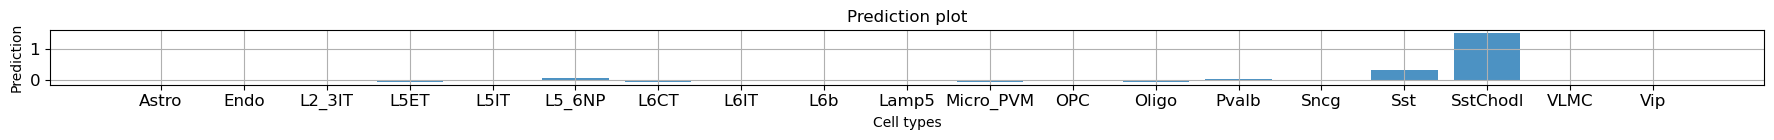

DeepBICCN2_base


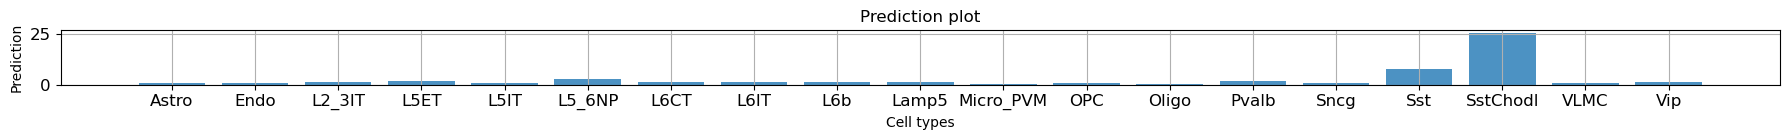

DeepBICCN2


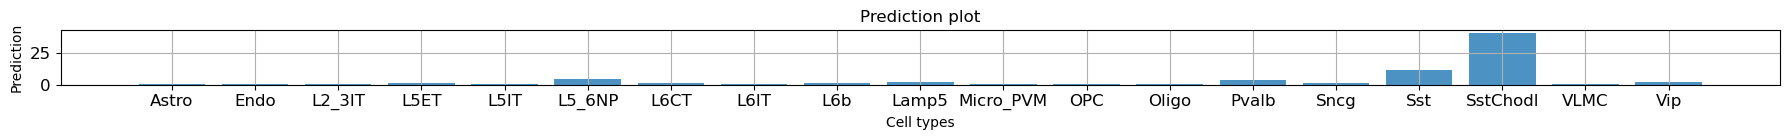

In [30]:
sequence = sequence
predictions = []
for model_ in models:
    prediction = crested.tl.predict(sequence, model=model_)
    predictions.append(prediction)
for i, pred in enumerate(predictions):
    print(model_names[i])
    crested.pl.bar.prediction(pred, classes=list(adata.obs_names), height=1.5)

DeepBICCN


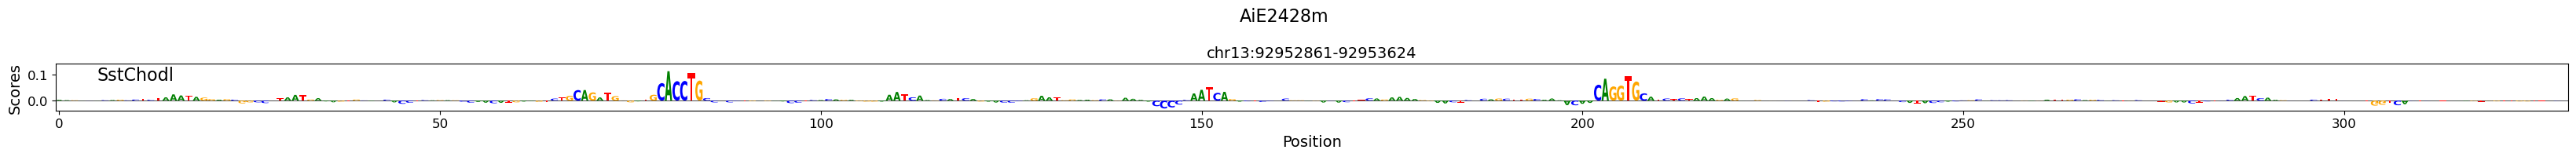

DeepBICCN2_base


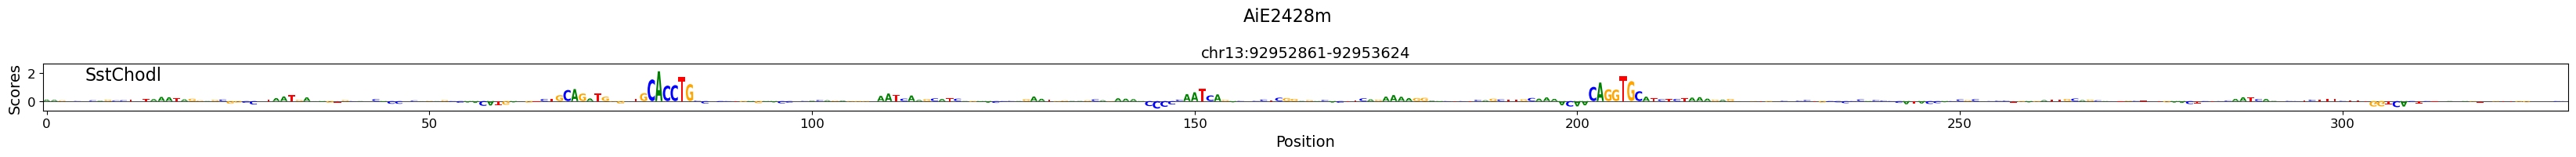

DeepBICCN2


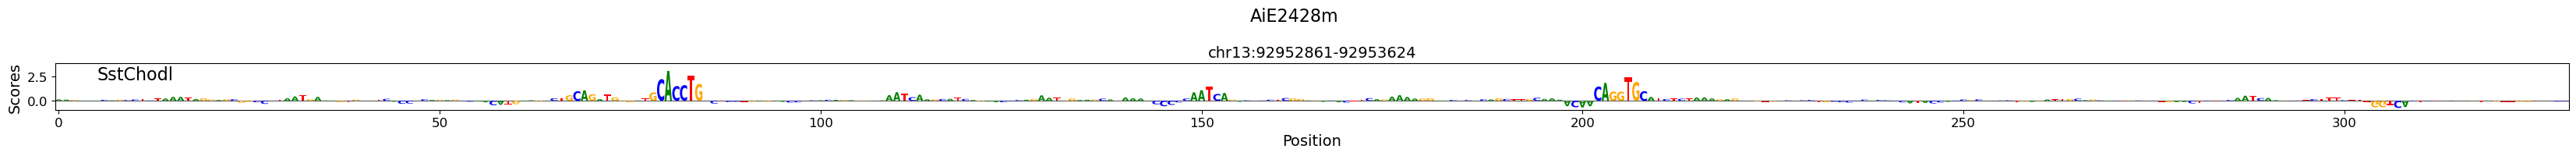

In [31]:
seq_len = row['end']-row['start']
pad_start=(2114-seq_len)//2
start=pad_start+225

end=start+330#pad_start+seq_len
one_hot_encoded_sequences_ = one_hot_encoded_sequences[:,start:end]
for i, score in enumerate(scores_list):
    score=score[:,:,start:end]
    print(model_names[i])
    crested.pl.patterns.contribution_scores(
        score,
        one_hot_encoded_sequences_,
        sequence_labels=[row['name']],
        class_labels=cts,
        #zoom_n_bases=seq_len,
        title=row['enhancerID'],
    )  # zoom in on the center 500bp

### Fig. 2f (top)

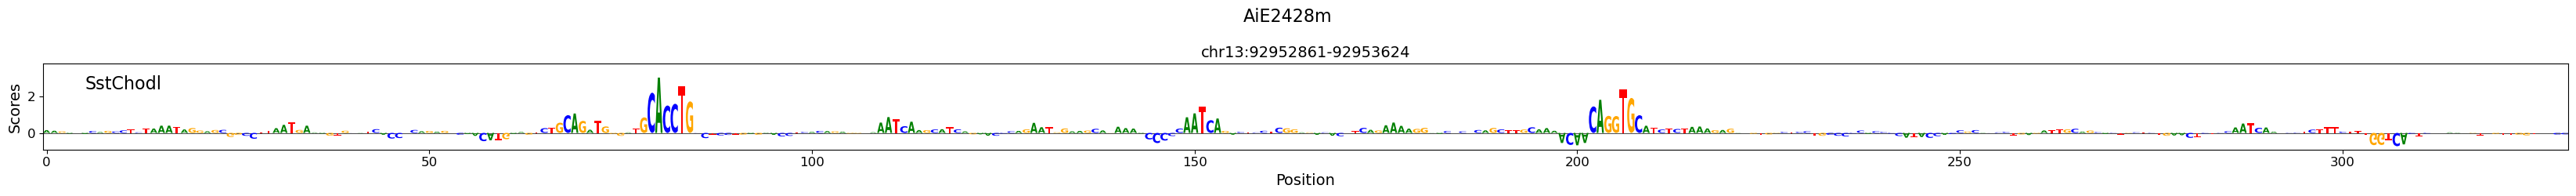

In [32]:
score=scores_list[2]
score = score[:,:,start:end]
crested.pl.patterns.contribution_scores(
    score,
    one_hot_encoded_sequences_,
    sequence_labels=[row['name']],
    class_labels=cts,
    #zoom_n_bases=seq_len,
    title=row['enhancerID'],
    #save_path=enhancerid+'.pdf',
    height=2.5
)  # zoom in on the center 500bp

### Sequence mutations

In [33]:
import re

def reverse_complement(sequence: str) -> str:
    """
    Compute the reverse complement of a DNA sequence.
    
    Args:
    - sequence (str): The DNA sequence.
    
    Returns:
    - str: The reverse complement of the sequence.
    """
    complement = str.maketrans("ACGTacgt", "TGCAtgca")
    return sequence.translate(complement)[::-1]

def find_pattern_in_sequence(sequence: str, pattern: str):
    """
    Find all occurrences of a pattern in a DNA sequence and return their positions.
    
    Args:
    - sequence (str): The DNA sequence to search within.
    - pattern (str): The DNA sequence pattern to search for (e.g., "ACGT").
    
    Returns:
    - list of tuples: A list of (start, end) positions for each match.
                       Start and end are 0-based indices.
    """
    # Use a regular expression to find all matches
    matches = [(match.start(), match.end()) for match in re.finditer(pattern, sequence)]
    
    return matches

def replace_pattern_in_sequence(sequence: str, pattern: str, replacement: str) -> str:
    """
    Replace all occurrences of a pattern in a DNA sequence with another pattern.
    
    Args:
    - sequence (str): The DNA sequence to search within.
    - pattern (str): The DNA sequence pattern to search for (e.g., "ACGT").
    - replacement (str): The DNA sequence pattern to replace the found matches with.
    
    Returns:
    - str: The updated DNA sequence with the pattern replaced.
    """
    # Use regular expression substitution to replace all matches
    updated_sequence = re.sub(pattern, replacement, sequence)
    return updated_sequence

In [34]:
scores_list, sequence, one_hot_encoded_sequences, cts, row, enhancerid = get_score_list(27,df,seqs_one_hot,models, cts_=['SstChodl', 'Sst'])

2025-03-20T15:41:46.578846+0100 INFO Calculating contribution scores for 2 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]

2025-03-20T15:41:49.099640+0100 INFO Calculating contribution scores for 2 class(es) and 1 region(s).



Model: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]

2025-03-20T15:41:51.614950+0100 INFO Calculating contribution scores for 2 class(es) and 1 region(s).



Model: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


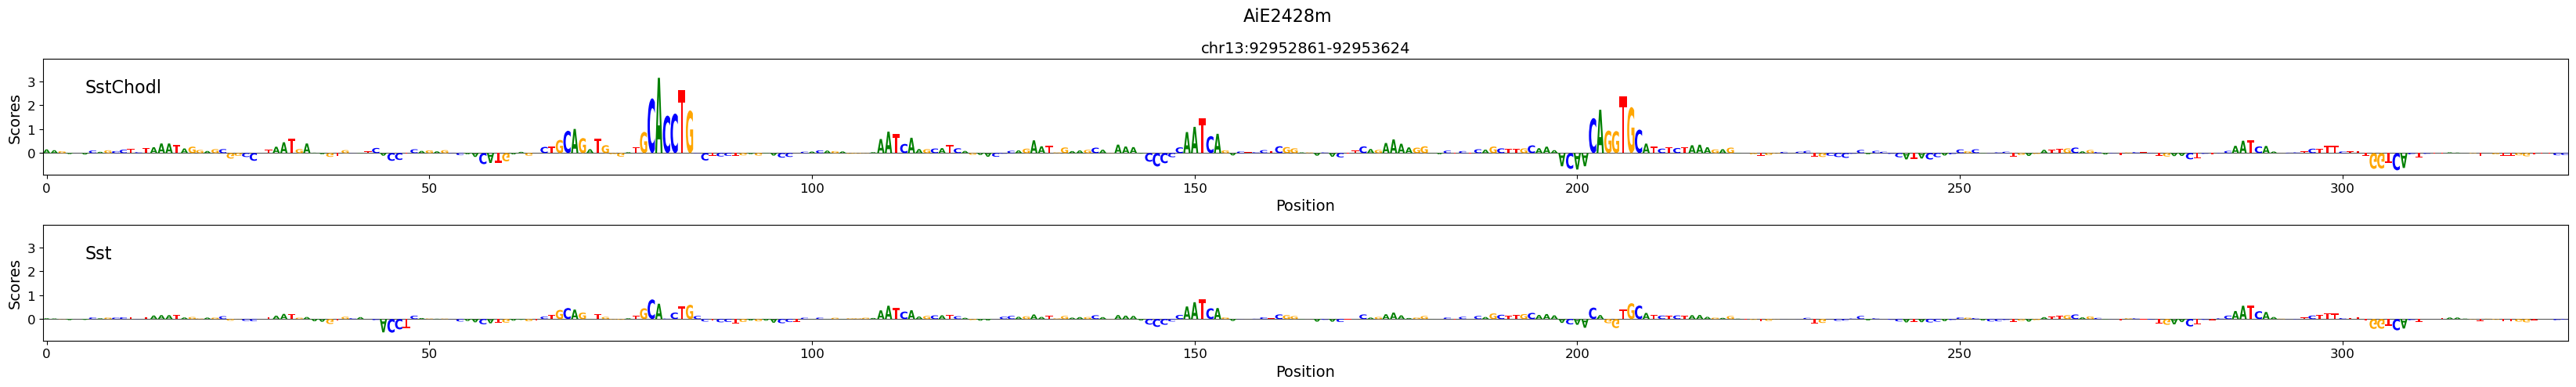

In [35]:
score=scores_list[2]
score = score[:,:,start:end]
crested.pl.patterns.contribution_scores(
    score,
    one_hot_encoded_sequences_,
    sequence_labels=[row['name']],
    class_labels=cts,
    #zoom_n_bases=seq_len,
    title=row['enhancerID'],
    #save_path=enhancerid+'.pdf',
    height=5
)  # zoom in on the center 500bp

In [36]:
# Example usage
pattern = "CACCTG"

positions = find_pattern_in_sequence(sequence, pattern)
print(positions)
replacement="CACGTG"
sequence2 = replace_pattern_in_sequence(sequence, pattern, replacement)
sequence3 = replace_pattern_in_sequence(sequence2, 'CAGGTG', 'CAGCTG')

#sequence3='A'*2114

positions = find_pattern_in_sequence(sequence2, replacement)
positions

[(979, 985)]


[(979, 985)]

In [37]:
class_idx = list(adata.obs_names.get_indexer(cts))
        
scores_list = []
for model_ in models:
    scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
        sequence3,
        target_idx=class_idx,
        model=model_,
    )
    scores_list.append(scores)

2025-03-20T15:41:56.924337+0100 INFO Calculating contribution scores for 2 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]

2025-03-20T15:41:59.429112+0100 INFO Calculating contribution scores for 2 class(es) and 1 region(s).



Model: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]

2025-03-20T15:42:01.930959+0100 INFO Calculating contribution scores for 2 class(es) and 1 region(s).



Model: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


#### fig. S3E

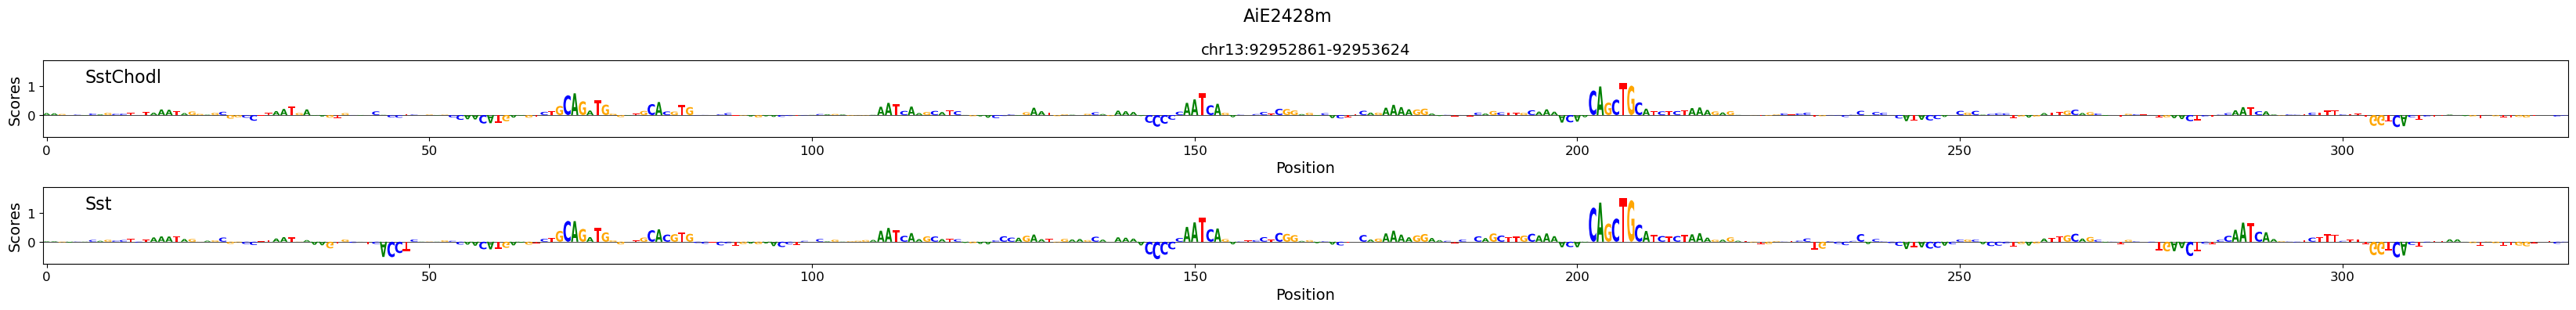

In [38]:
score=scores_list[1]
score = score[:,:,start:end]
one_hot_encoded_sequences_ = one_hot_encoded_sequences[:,start:end]

crested.pl.patterns.contribution_scores(
    score,
    one_hot_encoded_sequences_,
    sequence_labels=[row['name']],
    class_labels=cts,
    #zoom_n_bases=seq_len,
    title=row['enhancerID'],
    #save_path=enhancerid+'_w_Sst_MUT.pdf',
    height=4
)  # zoom in on the center 500bp

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


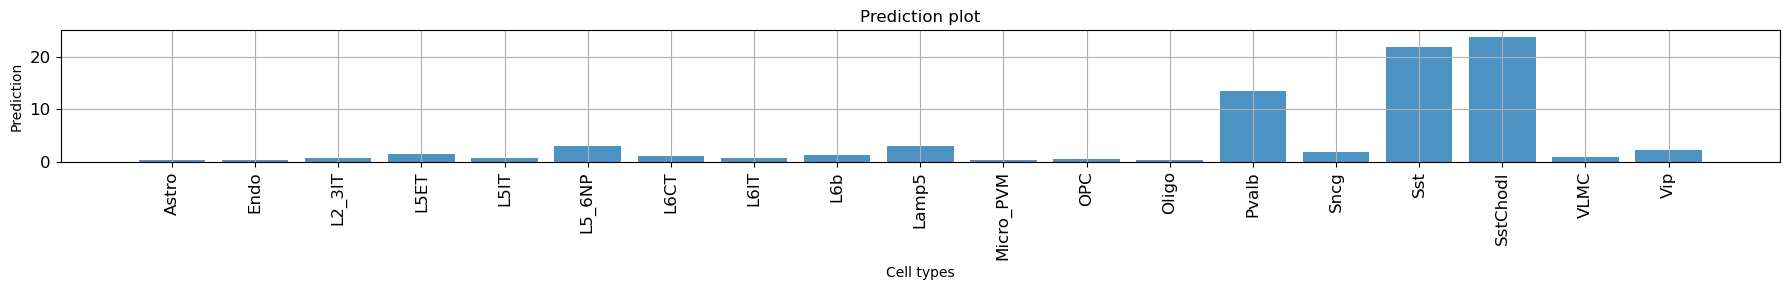

In [39]:
enhancerid = df.iloc[index]['enhancerID']
predictions = []
for model_ in models:
    prediction = crested.tl.predict(sequence3, model=model_)
    predictions.append(prediction)
crested.pl.bar.prediction(predictions[2], classes=list(adata.obs_names), height=3, x_label_rotation=90)#, save_path=enhancerid+'_pred_MUT.pdf')

## L6b enhancer AiE2587m

In [40]:
scores_list, sequence, one_hot_encoded_sequences, cts, row, enhancerid = get_score_list(114,df,seqs_one_hot, models)

2025-03-20T15:42:07.816999+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

2025-03-20T15:42:09.077141+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).



Model: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

2025-03-20T15:42:10.337995+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).



Model: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
DeepBICCN


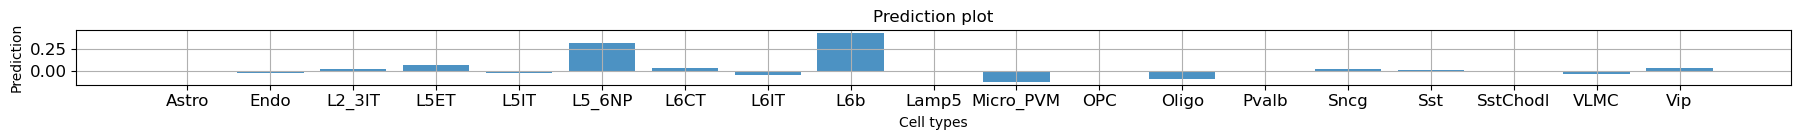

DeepBICCN2_base


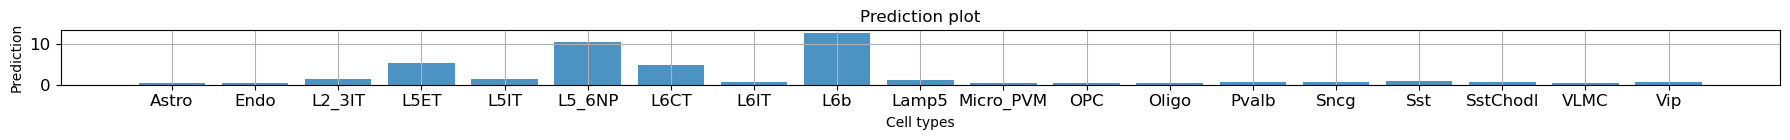

DeepBICCN2


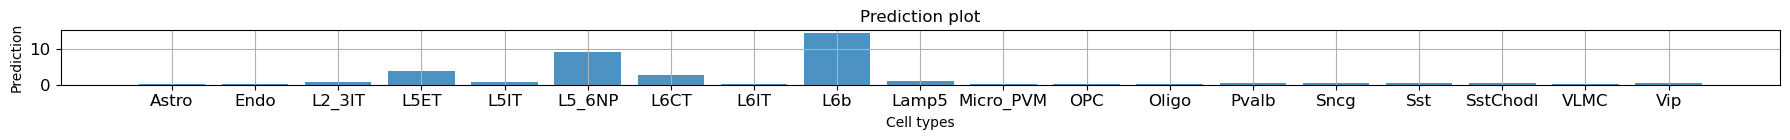

In [41]:
sequence = sequence
predictions = []
for model_ in models:
    prediction = crested.tl.predict(sequence, model=model_)
    predictions.append(prediction)
for i, pred in enumerate(predictions):
    print(model_names[i])
    crested.pl.bar.prediction(pred, classes=list(adata.obs_names), height=1.5)

DeepBICCN


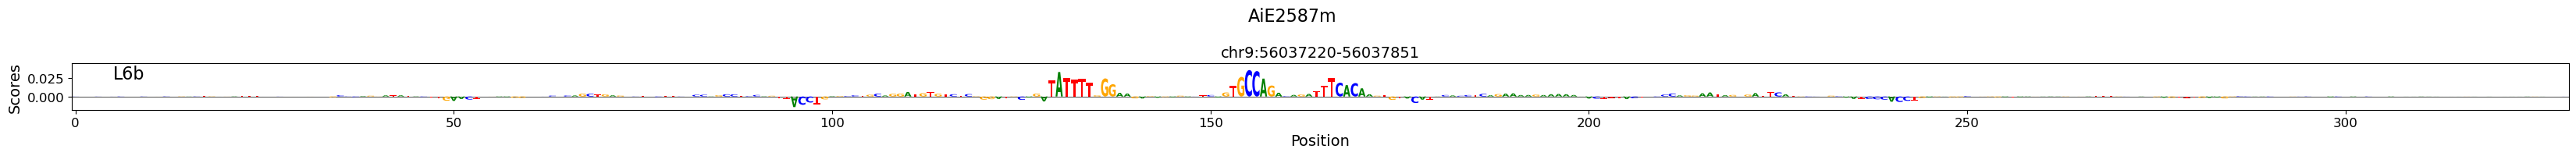

DeepBICCN2_base


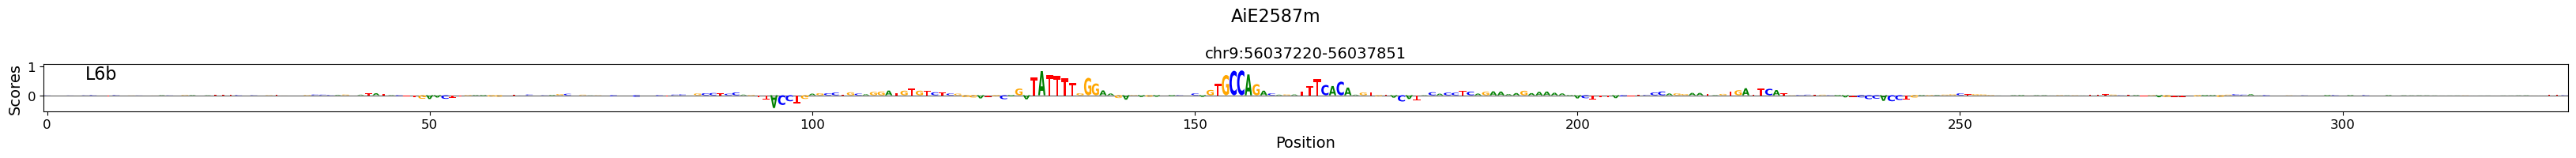

DeepBICCN2


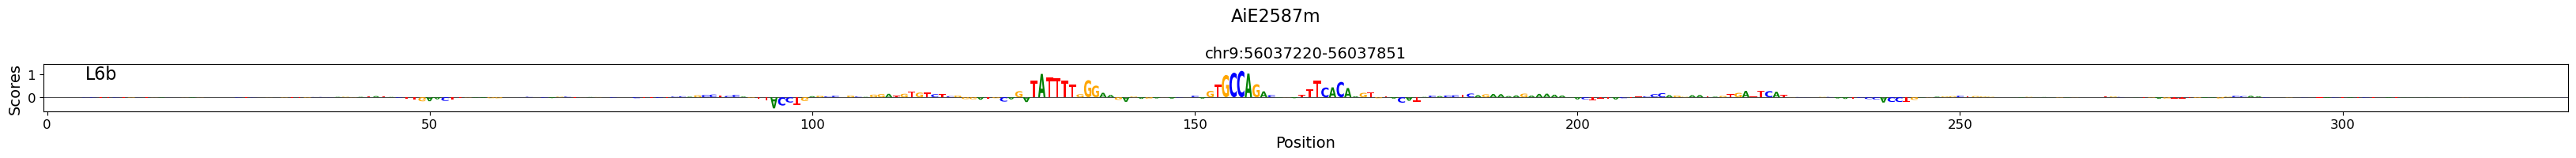

In [42]:
seq_len = row['end']-row['start']
pad_start=(2114-seq_len)//2
start=pad_start+275
end=start+330
one_hot_encoded_sequences_ = one_hot_encoded_sequences[:,start:end]
for i, score in enumerate(scores_list):
    score=score[:,:,start:end]
    print(model_names[i])
    crested.pl.patterns.contribution_scores(
        score,
        one_hot_encoded_sequences_,
        sequence_labels=[row['name']],
        class_labels=cts,
        #zoom_n_bases=seq_len,
        title=row['enhancerID'],
    )

### Fig. 2f (middle)

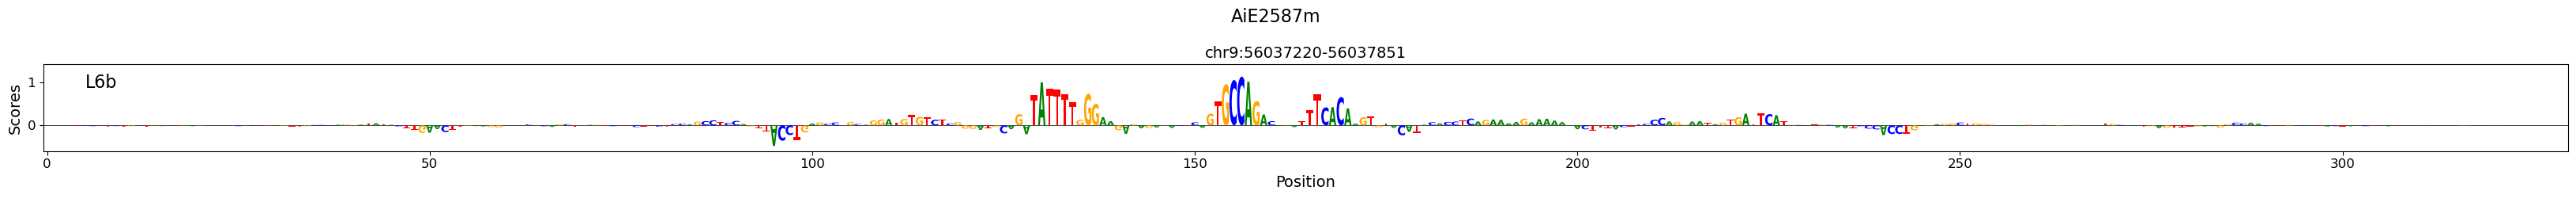

In [43]:
score=scores_list[2]
score = score[:,:,start:end]
crested.pl.patterns.contribution_scores(
    score,
    one_hot_encoded_sequences_,
    sequence_labels=[row['name']],
    class_labels=cts,
    title=row['enhancerID'],
    #save_path=enhancerid+'.pdf',
    height=2.5
)

## Oligo enhancer AiE0391h

In [44]:
scores_list, sequence, one_hot_encoded_sequences, cts, row, enhancerid = get_score_list(126,df,seqs_one_hot, models=models, cts_=['Oligo'])

2025-03-20T15:42:17.321582+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

2025-03-20T15:42:18.574796+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).



Model: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

2025-03-20T15:42:19.826022+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).



Model: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
DeepBICCN


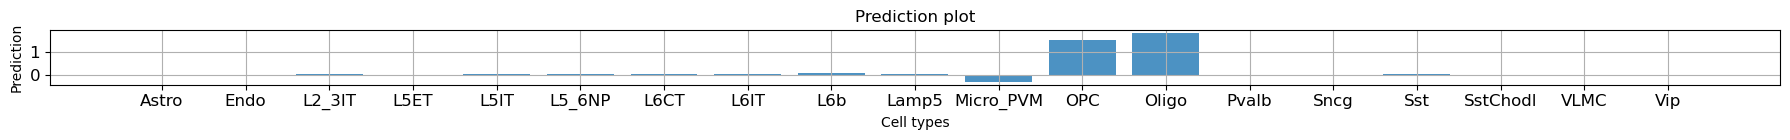

DeepBICCN2_base


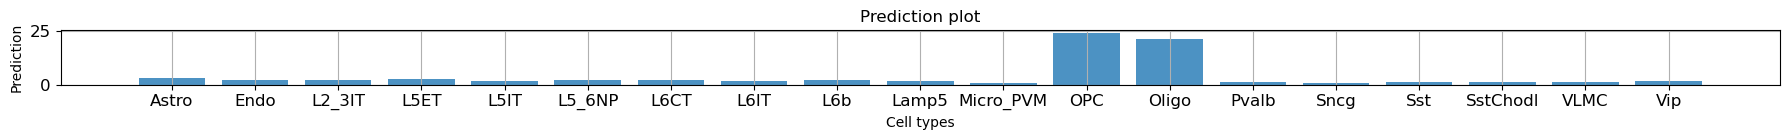

DeepBICCN2


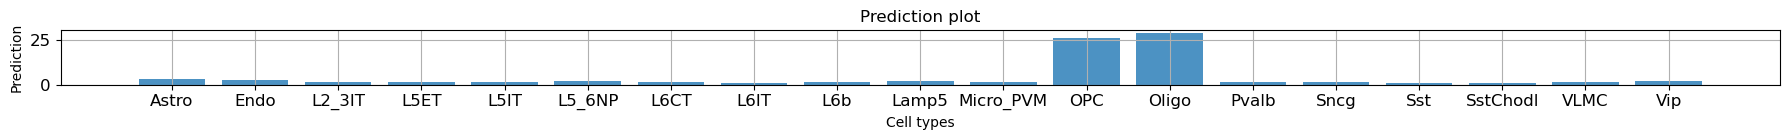

In [45]:
sequence = sequence
predictions = []
for model_ in models:
    prediction = crested.tl.predict(sequence, model=model_)
    predictions.append(prediction)
for i, pred in enumerate(predictions):
    print(model_names[i])
    crested.pl.bar.prediction(pred, classes=list(adata.obs_names), height=1.5)

DeepBICCN


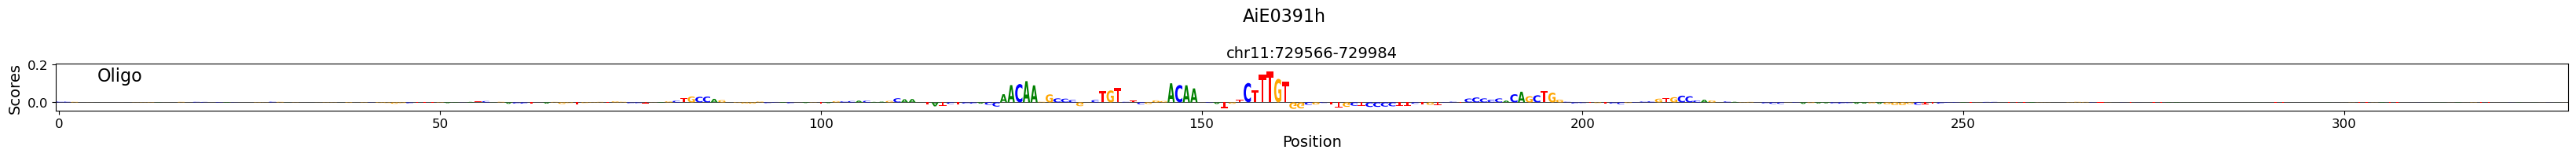

DeepBICCN2_base


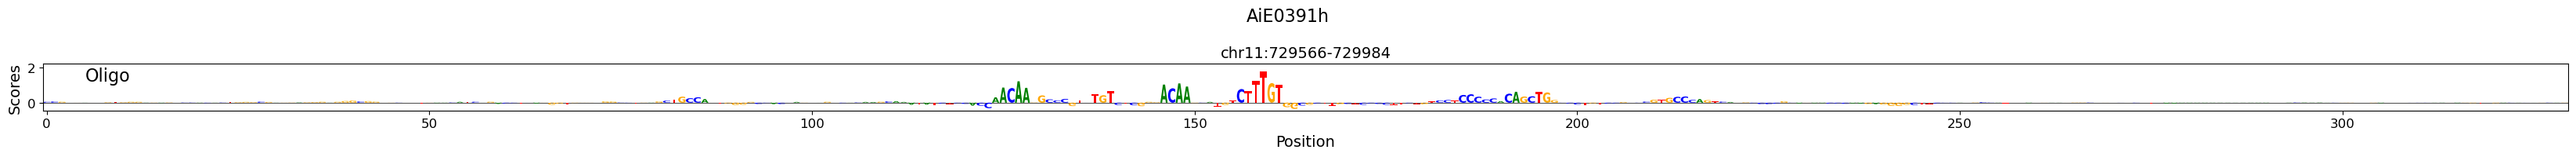

DeepBICCN2


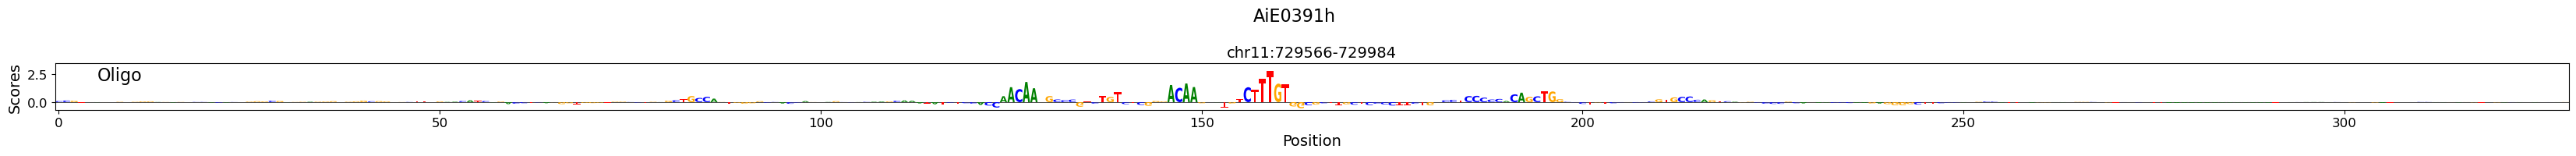

In [46]:
seq_len = row['end']-row['start']
pad_start=(2114-seq_len)//2
start=pad_start+50

end=start+330#pad_start+seq_len
one_hot_encoded_sequences_ = one_hot_encoded_sequences[:,start:end]
for i, score in enumerate(scores_list):
    score=score[:,:,start:end]
    print(model_names[i])
    crested.pl.patterns.contribution_scores(
        score,
        one_hot_encoded_sequences_,
        sequence_labels=[row['name']],
        class_labels=cts,
        #zoom_n_bases=seq_len,
        title=row['enhancerID'],
    )  # zoom in on the center 500bp

### Fig. 2f (bottom)

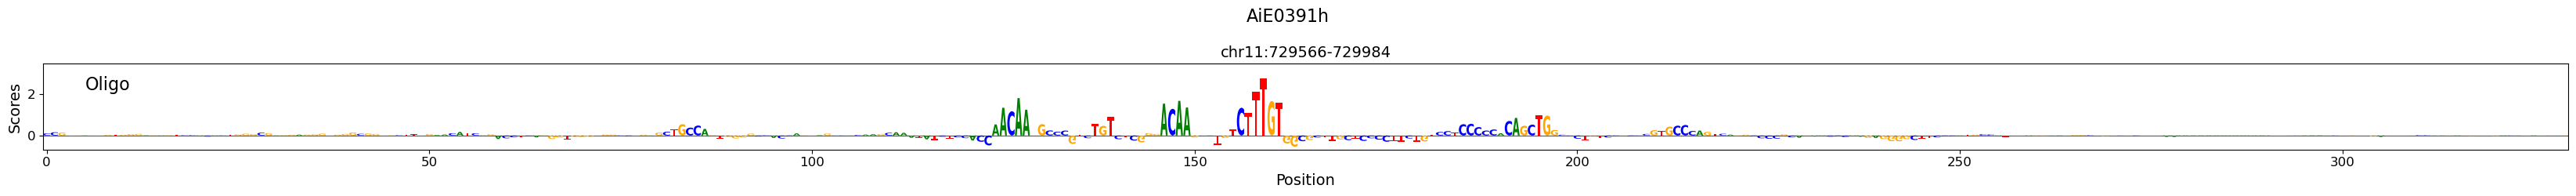

In [47]:
score=scores_list[2]
score = score[:,:,start:end]
crested.pl.patterns.contribution_scores(
    score,
    one_hot_encoded_sequences_,
    sequence_labels=[row['name']],
    class_labels=cts,
    #zoom_n_bases=seq_len,
    title=row['enhancerID'],
    #save_path=enhancerid+'.pdf',
    height=2.5
)  # zoom in on the center 500bp